In [1]:
using StatsBase

In [2]:
using HDF5
using PyPlot

In [180]:
fname = "Ising2D_L20_T0.8_wolff.h5"
Mtot = abs(h5read(fname, "energy"))
L = h5read(fname, "L")
N = L^2
T = h5read(fname, "T")
length(Mtot)

50001

# Onsager solution for magnetization

In [181]:
Tc = 1/(1/2*log(1+sqrt(2)))
if T<=1.0
    println("Test")
    global const Mexact = (1-sinh(2.0/(T*Tc))^(-4))^(1.0/8.0)
else
    println("Test2")
    global const Mexact = 0.0
end

Test


0.9544104119074902

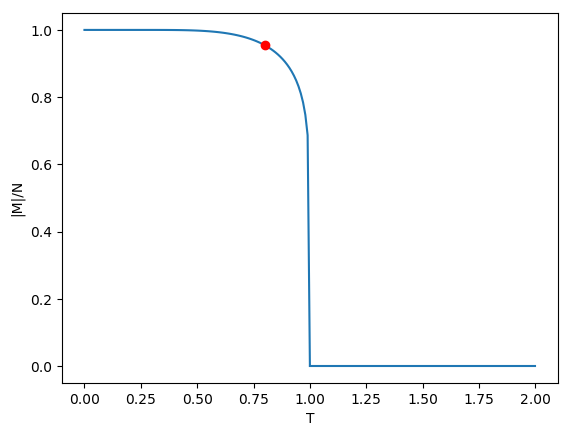

PyObject <matplotlib.text.Text object at 0x000000002D76A940>

In [182]:
x = linspace(0.0, 1.0, 100)
y = (1-sinh(2.0 ./ (x*Tc)).^(-4)).^(1/8)
plot(x,y)
plot(linspace(1.0, 2.0, 100), zeros(100), "C0")
plot([T], Mexact, "ro")
xlabel("T")
ylabel("|M|/N")

# Plot |M| and autocorrelation

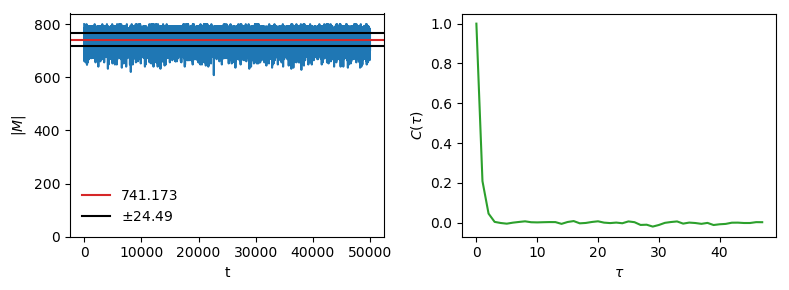

In [183]:
function plot_mag(M::Array{Float64, 1}, alt::Bool=false, err::Float64=std(M))
    fig, ax = subplots(1, 2, figsize=(8,3))

    if !alt
        ax[1][:plot](M)
        ax[1][:set_ylabel]("\$ |M| \$")
        ax[1][:set_xlabel]("t")
        ax[1][:axhline](mean(M), color="C3", label="$(round(mean(M), 3))")
        
        ax[1][:axhline](mean(M)+err, color="black", label="\$ \\pm $(round(err, 2)) \$")
        ax[1][:axhline](mean(M)-err, color="black")
        
        ax[1][:legend](frameon=false)
        
        ax[2][:plot](autocor(M), "-", color="C2")
        ax[2][:set_xlabel]("\$ \\tau \$")
        ax[2][:set_ylabel]("\$ C(\\tau) \$")
    else
        ax[1][:hist](M, 100)
        ax[1][:set_ylabel]("\$ P \$")
        ax[1][:set_xlabel]("|M|")
        ax[1][:set_yticks]([])
        ax[1][:axvline](mean(M), color="C3", label="$(round(mean(M), 3))")
        
        ax[1][:axvline](mean(M)+err, color="black", label="\$ \\pm $(round(err, 3)) \$")
        ax[1][:axvline](mean(M)-err, color="black")
        
        ax[1][:legend](frameon=false)
        
        
        try
            firstneg = find(x->x<=0, autocor(M))[1]
            ax[2][:semilogy](autocor(M)[1:firstneg-1], ".-", color="C2")
        catch
            ax[2][:semilogy](autocor(M), ".-", color="C2")
        end
        ax[2][:set_xlabel]("\$ \\tau \$")
        ax[2][:set_ylabel]("\$ C(\\tau) \$")
    end
    
    if maximum(M) <= 1.0 && minimum(M) >= 0.0
        if !alt
            ax[1][:set_ylabel]("\$ |M|/N \$")
            ax[1][:set_ylim]([-0.1, 1.1])
        end
    else
        if !alt
            mM = maximum(M)
            ax[1][:set_ylim]([-0.1, mM + 0.05*mM])
        end
    end

    tight_layout()
    return ax
end

plot_mag(Mtot, false);

# Throw away ~1000 thermalization steps

# Consider M=Mtot/N

In [184]:
M = Mtot[10002:end]/N
Nmeas=length(M)

, 1}) in module Main at In[152]:2 overwritten at In[183]:2.

40000

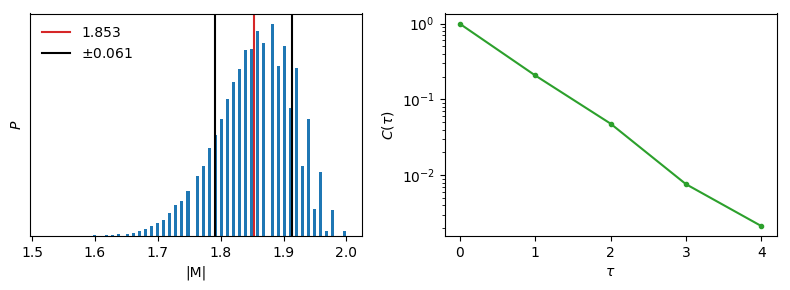

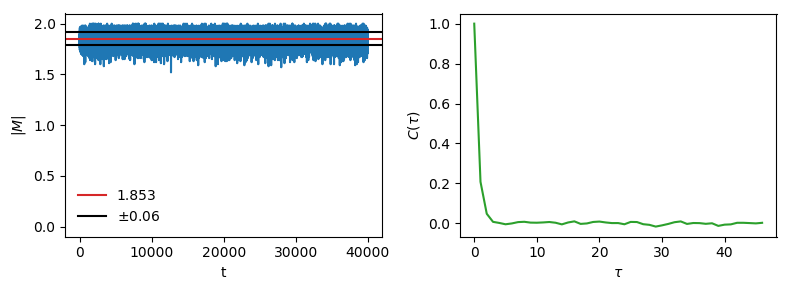

 at In[183]:2.


In [185]:
plot_mag(M, true);
plot_mag(M, false);

*Should both approach zero for Gaussian curve. (correct definition?)*

In [186]:
skewness(M)

-0.4752126358584723

In [187]:
kurtosis(M)

0.25163536804867226

# Autocorrelation time

The analysis above is naive in the sense that it assumes statistically independet datapoints. 
Of course, since generated from e.g. local spin flips, our data is highly correlated as can bee seen in the autocorrelation plots (autocor time).

Specifically, the formula

$ \sigma_\overline{X} = \sqrt{\frac{\sigma_X^2}{M}} $ becomes $ \sigma_\overline{X} = \sqrt{\frac{\sigma_X^2}{M}\left( 1+2\tau_X \right)} $.

This means that the number of independent datapoints is effectively reduced: $ M \rightarrow \frac{M}{1+2\tau_X} $

Defining $ \chi_{ij} = \langle x_i x_j \rangle - \langle x_i \rangle \langle x_j \rangle $ and assuming (translational invariance) $ \chi_{ij} = \chi_{|i-j|} = \chi_k = \langle x_k x_0 \rangle + \langle x \rangle^2$

The **autocorrelation time** is given by

$ \tau_x = \dfrac{\sum_{k=1}^{M-1} \left(1-\frac{k}{M}\right) \chi_k}{\sigma_X^2} $

$ \tau_x = \dfrac{\sum_{k=1}^{M-1} \left(1-\frac{k}{M}\right) \langle x_{0+k} x_0 \rangle + \langle x \rangle^2}{\sigma_X^2} \ \overset{M \rightarrow \infty}{\rightarrow} \ \dfrac{\sum_{k=1}^{\infty} \langle x_{0+k} x_0 \rangle + \langle x \rangle^2}{\sigma_X^2} $



### Integrated autocorrelation time

In [188]:
tau_int = sum(autocor(M))+0.5

1.7953059909964542

In [189]:
1+2*tau_int

4.590611981992908

### Autocorrelation from $C(\tau) \sim e^{-t/\tau}$ fit

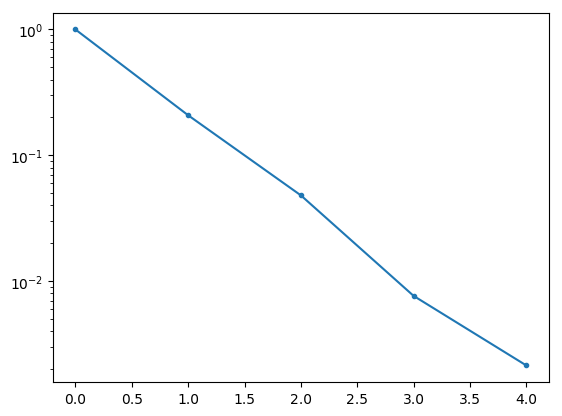

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000002CD2DB38>

In [190]:
logautocor = Float64[]
try
    firstneg = find(x->x<=0, autocor(M))[1]
    logautocor = log(autocor(M)[1:firstneg-1])
    semilogy(autocor(M)[1:firstneg-1], ".-")
catch
    logautocor = log(autocor(M))
    semilogy(autocor(M), ".-")
end
# ylim([0.01, 1.0])

In [191]:
using LsqFit

In [192]:
model(x,p) = p[1].*x+p[2]

pstart = [-1., 1.]

fitres = curve_fit(model, 1.0:1.0:length(logautocor), logautocor, pstart)

LsqFit.LsqFitResult{Float64,1}(3,[-1.55998,1.55439],[-0.00558388,0.00446129,-0.0900835,0.189119,-0.0979125],[1.0 1.0; 2.0 1.0; … ; 4.0 1.0; 5.0 1.0],true,Float64[])

In [193]:
tau_exp = -1/fitres.param[1]

0.6410343234363884

In [194]:
-1./mean(diff(logautocor))

0.6506618134603488

In [195]:
1+2*tau_exp

2.282068646872777

### Binning / Blocking analysis

If block is large enough such that block averages are independent and have common variance, one has

$\sigma_\overline{X}^2 = \dfrac{1}{N_{blocks}} \sigma_{\overline{X}_{block}}^2 $

Defining

$ R_X = \dfrac{m \sigma_{\overline{X}_{block}}^2}{\sigma_X^2}$

we can rewrite

$\sigma_\overline{X}^2 = R_X \dfrac{\sigma_{X}^2}{M} $

We estimate

$\sigma_{\overline{X}_{block}}^2 \approx \dfrac{1}{N_{blocks}-1} \sum_{j=1}^{N_{blocks}} (\overline{x}_j - \overline{x})^2 $

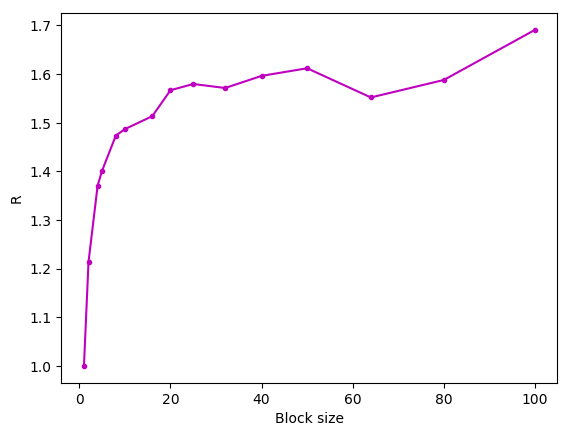

In [196]:
ms = Int[]
for m in 1:Nmeas
    if Nmeas%m ==0
        push!(ms, m)
    end
end

# ms = ms[1:15]
ms = ms[(ms./Nmeas) .< 0.003]

R = Float64[]
for m in ms
    # m = Int(Nmeas/n_blocks)
    n_blocks = Int(Nmeas/m)

    blockmeans = vec(mean( reshape(M, (m,n_blocks)), 1))

    blocksigma2 = 1/(n_blocks-1)*sum((blockmeans - mean(M)).^2)

    Ri = m * blocksigma2 / var(M)
    push!(R, Ri)
end

plot(ms, R, "m.-")
xlabel("Block size")
ylabel("R");

In [197]:
tau = 1/2*(R[ms .== 100][1]-1)

0.34526562481056844

# Effect of autocorrelation times

In [198]:
tau

0.34526562481056844

In [199]:
tau_int

1.7953059909964542

In [200]:
tau_exp

0.6410343234363884

In [201]:
# err = sqrt(var(M)*(2*tau_int))
err = sqrt(var(M)*(1+2*tau_exp))

0.09237392250423576

In [202]:
(mean(M)-err, mean(M)+err)

(1.7603298274957642,1.9450776725042356)

In [203]:
abs(Mexact-mean(M))

0.8982933380925097

In [204]:
Mexact

0.9544104119074902

In [205]:
mean(M)

1.8527037499999999

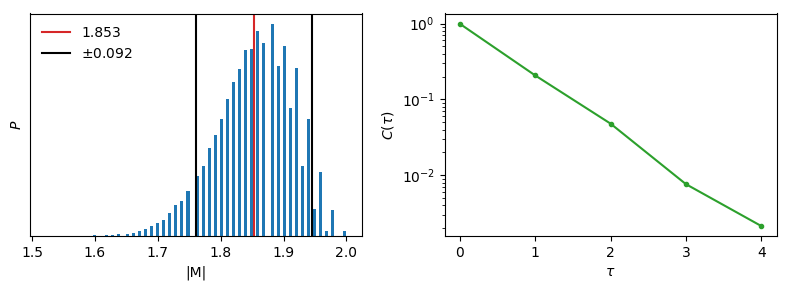

2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x0000000030ABC898>
 PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x0000000030C73320>

In [206]:
ax = plot_mag(M, true, err)
# ax[1][:set_xlim]([-0.2, 1.2])

In [207]:
Nmeas_eff = round(Int, Nmeas/(2*tau_int))

11140

In [208]:
mean(M[round(Int, linspace(1, length(M), Nmeas_eff))])

1.8532603231597842

In [209]:
Nmeas/Nmeas_eff

3.5906642728904847

10000-element Array{Float64,1}:
 0.94 
 0.975
 0.95 
 0.98 
 0.985
 0.98 
 0.98 
 0.96 
 0.96 
 0.94 
 0.97 
 0.94 
 0.975
 ⋮    
 0.96 
 0.955
 0.96 
 0.94 
 0.965
 0.985
 0.97 
 0.95 
 0.935
 0.96 
 0.965
 0.975